<a href="https://colab.research.google.com/github/gad69/COMPUTER_vision/blob/main/YOLOv4_Roboflow_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, we implement [YOLOv4](https://arxiv.org/pdf/2004.10934.pdf) for training on your own dataset in PyTorch.

We also recommend reading our blog post on [Training YOLOv4 on custom data](https://blog.roboflow.ai/training-yolov4-on-a-custom-dataset/) side by side.

We will take the following steps to implement YOLOv4 on our custom data:
* Set up YOLOv4 environment
* Download Custom Dataset via Roboflow
* Train Custom YOLOv4 detector
* Reload Custom YOLOv4 detector weights for inference

When you are done you will have a custom detector that you can use. It will make inference like this:

#### ![Chesse Image](https://i.imgur.com/cGOxffX.png)

### **Reach out for support**

If you run into any hurdles on your own data set or just want to share some cool results in your own domain, [reach out!](https://roboflow.ai/contact) 


#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)

# Set up YOLOv4 Environment

In [1]:
!git clone https://github.com/roboflow-ai/pytorch-YOLOv4.git

Cloning into 'pytorch-YOLOv4'...
remote: Enumerating objects: 398, done.
remote: Total 398 (delta 0), reused 0 (delta 0), pack-reused 398
Receiving objects: 100% (398/398), 926.53 KiB | 20.14 MiB/s, done.
Resolving deltas: 100% (225/225), done.


In [ ]:
%cd /content/pytorch-YOLOv4
!pip install -r requirements.txt
# This restarts the runtime--ignore any error messages
import os
os.kill(os.getpid(), 9)

/content/pytorch-YOLOv4
     |████████████████████████████████| 20.2MB 1.4MB/s 
     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 12.6MB 207kB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 122kB 63.1MB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.3 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirem

In [1]:
# download yolov4 weights that have already been converted to PyTorch
%cd /content/pytorch-YOLOv4/cfg/
!gdown https://drive.google.com/uc?id=1fcbR0bWzYfIEdLJPzOsn4R5mlvR6IQyA

/content/pytorch-YOLOv4/cfg
Downloading...
From: https://drive.google.com/uc?id=1fcbR0bWzYfIEdLJPzOsn4R5mlvR6IQyA
To: /content/pytorch-YOLOv4/cfg/yolov4.conv.137.pth
170MB [00:02, 76.7MB/s]


# Download Custom Dataset

## Export Your Dataset from Roboflow

Roboflow enables you to export your dataset in any format you need - including for this notebook.

Create a [free account](https://app.roboflow.ai). Upload your private dataset. Generate a version (applying any preprocessing and augmentations you desire). Create an export. Select **YOLOv4 PyTorch** as the export format. Click **"Show Download code"**, copy your link, and paste it in the next cell. Magic.

In [2]:
%cd /content/
# REPLACE this link with your Roboflow dataset (export as YOLOv4 PyTorch format)
!curl -L "https://app.roboflow.com/ds/dJx5UqLqrl?key=BXv8Tru0z7" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1580      0 --:--:-- --:--:-- --:--:--  1577
100 26.3M  100 26.3M    0     0  27.8M      0 --:--:-- --:--:-- --:--:-- 27.8M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/0152fe113f55f6c0_jpg.rf.ecdf762a8ed655ab7ecf6e70eae06d75.jpg  
 extracting: test/018deaf2ea7f1aa5_jpg.rf.179404b5e5aee0ddfc2a07f8ef908d67.jpg  
 extracting: test/01a87d30eaefed91_jpg.rf.4d422ca83a02e7b8a8a35ab013366450.jpg  
 extracting: test/02d56b2f2759bffa_jpg.rf.271df514b83485e646e9d50a901e00cd.jpg  
 extracting: test/02dc60e7b13e6dda_jpg.rf.be700d9f595cd728d09b8a800c7bba76.jpg  
 extracting: test/0578555cc80e2ecc_jpg.rf.e49000afe70e7fa109646ad238fec03f.jpg  
 extracting: test/064068705af4ecab_jpg.rf.2bc13f6dd63948eaeb9bcd9de7206605.jpg  
 extracting: test/09060776fd

In [3]:
%cp train/_annotations.txt train/train.txt
%cp train/_annotations.txt train.txt
%mkdir data
%cp valid/_annotations.txt data/val.txt
%cp valid/*.jpg train/

In [4]:
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('train/_classes.txt')

In [5]:
print(num_classes)

1


# Train Custom Detector

In [6]:
#start training
#-b batch size (you should keep this low (2-4) for training to work properly)
#-s number of subdivisions in the batch, this was more relevant for the darknet framework
#-l learning rate
#-g direct training to the GPU device
#pretrained invoke the pretrained weights that we downloaded above
#classes - number of classes
#dir - where the training data is
#epoch - how long to train for
!python ./pytorch-YOLOv4/train.py -b 2 -s 1 -l 0.001 -g 0 -pretrained /content/pytorch-YOLOv4/cfg/yolov4.conv.137.pth -classes {num_classes} -dir ./train -epochs 50

log file path:log/log_2021-04-12_13-28-38.txt
2021-04-12 13:28:38,571 train.py[line:435] INFO: Using device cuda
2021-04-12 13:28:41,734 train.py[line:282] INFO: Starting training:
        Epochs:          50
        Batch size:      2
        Subdivisions:    1
        Learning rate:   0.001
        Training size:   1065
        Validation size: 105
        Checkpoints:     True
        Device:          cuda
        Images size:     608
        Optimizer:       adam
        Dataset classes: 1
        Train label path:train.txt
        Pretrained:
    
Epoch 1/50:   0%|       | 0/1065 [00:00<?, ?img/s]/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch 1/50:   4%| | 38/1065 [00:09<03:12,  5.35img/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler

# Load Trained Weights for Custom Detection

You can also use this to load previously saved weights!

In [7]:
#looking at the weights that our model has saved during training
!ls checkpoints

Yolov4_epoch10.pth  Yolov4_epoch2.pth  Yolov4_epoch5.pth  Yolov4_epoch8.pth
Yolov4_epoch11.pth  Yolov4_epoch3.pth  Yolov4_epoch6.pth  Yolov4_epoch9.pth
Yolov4_epoch1.pth   Yolov4_epoch4.pth  Yolov4_epoch7.pth


In [13]:
#choose random test image
img_path = "/content/wath.jpg"

In [14]:
%%time
##change the epoch here to the one you would like to use for inference
!python /content/pytorch-YOLOv4/models.py {num_classes} checkpoints/Yolov4_epoch11.pth {img_path} test/_classes.txt

Watch: 1.000000
Watch: 1.000000
Watch: 1.000000
Watch: 1.000000
Watch: 1.000000
Watch: 1.000000
save plot results to predictions.jpg
CPU times: user 26.1 ms, sys: 4.52 ms, total: 30.6 ms
Wall time: 4.63 s


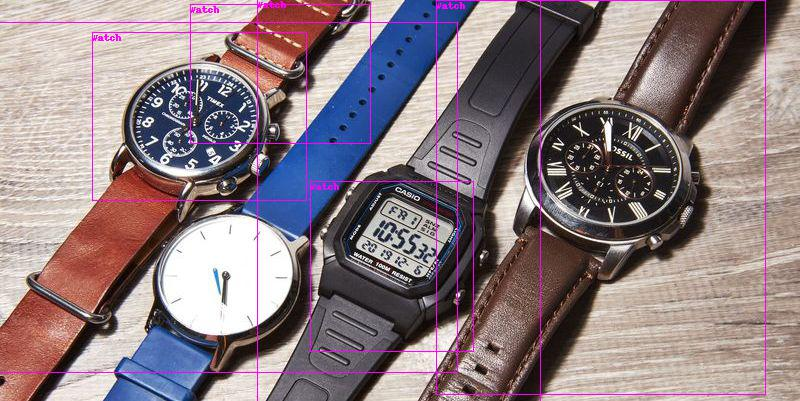

In [15]:
#visualize inference
from IPython.display import Image
Image('predictions.jpg')